# Lightning

In [1]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics import MinMetric, MeanMetric
from PIL import Image
from xml.etree import ElementTree as ET
from typing import Any, Tuple
from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v2
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
import numpy as np
import cv2


class FaceDataset(Dataset):
    def __init__(self, path, data_dir: str) -> None:
        super().__init__()
        self.images = ET.parse(path).getroot()[2]
        self.data_dir = data_dir
        
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Any:
        data = self.images[index]
        true_width = int(data.attrib['width'])
        true_height = int(data.attrib['height'])
        left = int(data[0].attrib['left'])
        top = int(data[0].attrib['top'])
        width = int(data[0].attrib['width'])
        height = int(data[0].attrib['height'])
        transforms = A.Compose([
            A.Crop(x_min=max(0, left), y_min=max(0, top), x_max=min(left + width, true_width), 
                   y_max=min(top + height, true_height)),
            A.Resize(244, 244),
            A.Normalize(),
            ToTensorV2(),
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        landmarks = []
        for landmark in data[0]:
            landmarks.append((float(landmark.attrib['x']), float(landmark.attrib['y'])))
        transformed = transforms(
            image=np.array(Image.open(self.data_dir + data.attrib['file']).convert('RGB')), 
            keypoints=landmarks)
        image = transformed['image']
        landmarks = torch.tensor(transformed['keypoints']).flatten() / 244
        return image, landmarks
    
class FaceDataModule(LightningDataModule):
    def __init__(
        self,
        train_val_split: Tuple[int, int] = (0.8, 0.2),
        data_dir: str = "./data/",
        batch_size: int = 64,
        num_workers: int = 0,
    ) -> None:
        super().__init__()
        self.num_workers = num_workers
        self.train_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'
        self.test_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml'
        train_dataset = FaceDataset(self.train_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')
        (self.data_train, self.data_val) = random_split(
            dataset=train_dataset,
            lengths=train_val_split,
            generator=torch.Generator().manual_seed(42),
        )
        self.data_test: Dataset = FaceDataset(self.test_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')

        self.batch_size_per_device = batch_size

    @property
    def num_classes(self) -> int:
        return 136

    def train_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

class FaceModule(LightningModule):
    def __init__(self, n_classes: int = 136, lr: float = 1e-4) -> None:
        super().__init__()
        self.save_hyperparameters(logger=False)
        # self.net = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
        self.net = mobilenet_v2(pretrained=False)
        self.net.classifier = torch.nn.Linear(1280, self.hparams.n_classes)
        self.criterion = torch.nn.MSELoss()

         # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_loss_best = MinMetric()

    def on_train_start(self) -> None:
        self.train_loss.reset()
        self.val_loss.reset()
        self.val_loss_best.reset()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    def configure_optimizers(self) -> Any:
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.train_loss(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.val_loss(loss)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.test_loss(loss)
        self.log("test_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss
    
    def predict_step(self, img: Image) -> Any:
        t = A.Compose([
            A.Resize(244, 244),
            A.Normalize(),
            ToTensorV2(),
        ])
        transformed = t(image=np.array(img))
        image = transformed['image'].to(self.device)
        logits = self.forward(image.unsqueeze(0))
        return logits.squeeze(0)
    
    def on_validation_epoch_end(self) -> None:
        def draw(image, landmarks):
            # draw image and point landmarks
            image = image.copy()
            for landmark in landmarks:
                cv2.circle(image, (landmark[0], landmark[1]), 1, (0, 255, 0), 3)
            plt.imshow(image)
        acc = self.val_loss.compute()  # get current val loss
        self.val_loss_best(acc)  # update best so far val loss
        self.log("val_loss_best", self.val_loss_best.compute(), sync_dist=True, prog_bar=True)

        # view 
        img = Image.open('../data/ibug_300W_large_face_landmark_dataset/ibug/image_003_1.jpg')
        landmarks = self.predict_step(img)
        landmarks = landmarks.cpu().detach().numpy().reshape((68, 2)) * np.array([img.width, img.height])
        landmarks = landmarks.astype(int)
        draw(np.array(img), landmarks)

    def save_to_state_dict(self, path: str):
        torch.save(self.state_dict(), path)

    def load_from_state_dict(self, path: str):
        self.load_state_dict(torch.load(path))
     

c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
model = FaceModule()
datamodule = FaceDataModule(data_dir='../data/', batch_size=16, num_workers=0, train_val_split=(0.8, 0.2))
model = FaceModule()
trainer = Trainer(
    max_epochs=20,
    callbacks=[EarlyStopping(monitor="val_loss")],
    accelerator="gpu",
    devices=1,
)

c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this re

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type        | Params
----------------------------------------------
0 | net           | MobileNetV2 | 2.4 M 
1 | criterion     | MSELoss     | 0     
2 | train_loss    | MeanMetric  | 0     
3 | val_loss      | MeanMetric  | 0     
4 | test_loss     | MeanMetric  | 0     
5 | val_loss_best | MinMetric   | 0     
----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.592     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 334/334 [02:57<00:00,  1.88it/s, v_num=2, train_loss=0.00106, val_loss=0.00147, val_loss_best=0.00252] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 334/334 [02:57<00:00,  1.88it/s, v_num=2, train_loss=0.00106, val_loss=0.00147, val_loss_best=0.00252]


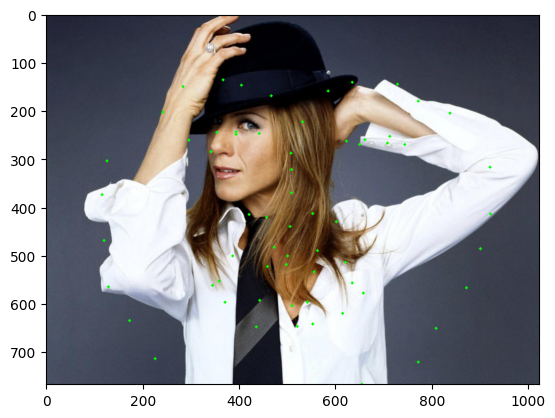

In [3]:
trainer.fit(model, datamodule=datamodule)

c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\letua\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


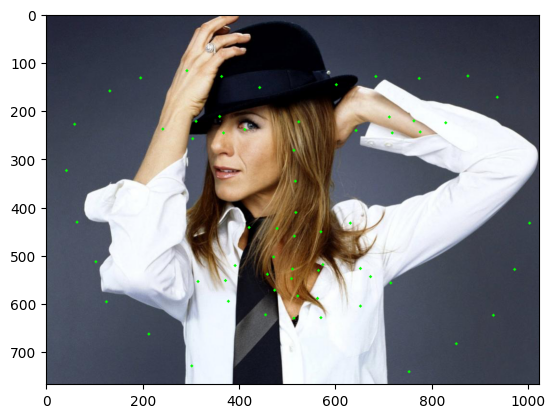

In [6]:
# Predict
from PIL import Image
import cv2
from matplotlib import pyplot as plt


def draw(image, landmarks):
    # draw image and point landmarks
    image = image.copy()
    for landmark in landmarks:
        cv2.circle(image, (landmark[0], landmark[1]), 1, (0, 255, 0), 3)
    plt.imshow(image)
    

img = Image.open('../data/ibug_300W_large_face_landmark_dataset/ibug/image_003_1.jpg')
path = './lightning_logs/version_2/checkpoints/epoch=19-step=6680.ckpt'

model = FaceModule.load_from_checkpoint(path).to('cuda')
landmarks = model.predict_step(img=img)
landmarks = landmarks.cpu().detach().numpy().reshape((68, 2)) * np.array([img.width, img.height])
landmarks = landmarks.astype(int)

draw(np.array(img), landmarks)